# Run the three-layer IRM

This notebook will demonstrate the inclusion of ocean heat uptake.

We will use example forcing from RFMIP to demonstrate.

In [1]:
import os

import numpy as np
import matplotlib.pyplot as pl
import pandas as pd
import scipy.linalg
import scipy.stats
import json
from tqdm import tqdm

In [2]:
df = pd.read_csv(
    os.path.join("..", "data", "calibration", "4xCO2_cummins.csv")
)

In [3]:
models = df['model'].unique()
models

array(['ACCESS-CM2', 'ACCESS-ESM1-5', 'AWI-CM-1-1-MR', 'BCC-CSM2-MR',
       'BCC-ESM1', 'CAMS-CSM1-0', 'CESM2-FV2', 'CESM2-WACCM',
       'CESM2-WACCM-FV2', 'CMCC-CM2-SR5', 'CNRM-CM6-1', 'CNRM-CM6-1-HR',
       'CNRM-ESM2-1', 'CanESM5', 'E3SM-1-0', 'FGOALS-g3', 'GISS-E2-1-G',
       'GISS-E2-1-H', 'GISS-E2-2-G', 'HadGEM3-GC31-LL', 'HadGEM3-GC31-MM',
       'MIROC-ES2L', 'MIROC6', 'MPI-ESM1-2-HR', 'MPI-ESM1-2-LR',
       'MRI-ESM2-0', 'NorCPM1', 'SAM0-UNICON'], dtype=object)

In [4]:
params = {}
for model in models:
    params[model] = {}
    for run in df.loc[df['model']==model, 'run']:
        condition = (df['model']==model) & (df['run']==run)
        params[model][run] = {}
        params[model][run]['gamma_autocorrelation'] = df.loc[condition, 'gamma'].values[0]
        params[model][run]['ocean_heat_capacity'] = df.loc[condition, 'C1':'C3'].values.squeeze()
        params[model][run]['ocean_heat_transfer'] = df.loc[condition, 'kappa1':'kappa3'].values.squeeze()
        params[model][run]['deep_ocean_efficacy'] = df.loc[condition, 'epsilon'].values[0]
        params[model][run]['sigma_eta'] = df.loc[condition, 'sigma_eta'].values[0]
        params[model][run]['sigma_xi'] = df.loc[condition, 'sigma_xi'].values[0]
        params[model][run]['forcing_4co2'] = df.loc[condition, 'F_4xCO2'].values[0]

In [6]:
# TODO: move to a constants module

NBOX = 3  # hard code for now, to do is a truly flexible model
EARTH_RADIUS = 6.371e6  # m
SECONDS_PER_YEAR = 365.2425 * 24 * 60 * 60  # we can be cleverer about this
DOUBLING_TIME_1PCT = np.log(2)/np.log(1.01)  # about 69.7
forcing_2co2_4co2_ratio=0.476304  # TODO: un-hardcode this and calculate directly from Meinshausen or Etminan relations.

In [41]:
class EnergyBalanceModel:
    
    # Energy balance basics
    ocean_heat_capacity = np.array([5, 20, 100])
    ocean_heat_transfer = np.array([1, 2, 1])
    deep_ocean_efficacy = 1

    # Tuning
    forcing_4co2 = 8
    
    # Stochastic parameters (see Cummins et al. 2020)
    stochastic_run = False
    sigma_eta = 0.5
    sigma_xi = 0.5
    gamma_autocorrelation = 2
    seed = None

    # Output
    start = 1850.0
    end = 2101.0
    timestep = 0.2
    outtime = None,
    #forcing = np.zeros(2)
    
    def __init__(self, **kwargs):
        self.ocean_heat_capacity = kwargs.get('ocean_heat_capacity', self.ocean_heat_capacity)
        self.ocean_heat_transfer = kwargs.get('ocean_heat_transfer', self.ocean_heat_transfer)
        self.deep_ocean_efficacy = kwargs.get('deep_ocean_efficacy', self.deep_ocean_efficacy)
        self.forcing_4co2 = kwargs.get('forcing_4co2', self.forcing_4co2)
        self.stochastic_run = kwargs.get('stochastic_run', self.stochastic_run)
        self.sigma_eta = kwargs.get('sigma_eta', self.sigma_eta)
        self.sigma_xi = kwargs.get('sigma_xi', self.sigma_xi)
        self.gamma_autocorrelation = kwargs.get('gamma_autocorrelation', self.gamma_autocorrelation)
        self.start = kwargs.get('start', self.start)
        self.end = kwargs.get('end', self.end)
        self.timestep = kwargs.get('timestep', self.timestep)
        self.outtime = kwargs.get('outtime', self.outtime)
        self.seed = kwargs.get('seed', self.seed)
        #self.forcing = kwargs.get('forcing', self.forcing)

    def _eb_matrix(self):
        # Define the matrix of differential equations
        # Cummins et al. (2020); Leach et al. (2021)
        eb_matrix = np.array(
            [
                [
                    -(self.ocean_heat_transfer[0]+self.ocean_heat_transfer[1])/self.ocean_heat_capacity[0],
                    self.ocean_heat_transfer[1]/self.ocean_heat_capacity[0], 
                    0
                ],
                [
                    self.ocean_heat_transfer[1]/self.ocean_heat_capacity[1],
                    -(self.ocean_heat_transfer[1]+self.deep_ocean_efficacy*self.ocean_heat_transfer[2])/self.ocean_heat_capacity[1],
                    self.deep_ocean_efficacy*self.ocean_heat_transfer[2]/self.ocean_heat_capacity[1]
                ],
                [
                    0, 
                    self.ocean_heat_transfer[2]/self.ocean_heat_capacity[2],
                    -self.ocean_heat_transfer[2]/self.ocean_heat_capacity[2]
                ]
            ]
        )
        return(eb_matrix)
    
        
    def impulse_response(self):
        eb_matrix = self._eb_matrix()

        # calculate the eigenvectors and eigenvalues, these are the timescales of responses
        eb_matrix_eigenvalues, eb_matrix_eigenvectors = scipy.linalg.eig(eb_matrix)
        self.timescales = -1/(np.real(eb_matrix_eigenvalues))
        self.response_coefficients = self.timescales * (eb_matrix_eigenvectors[0,:] * scipy.linalg.inv(eb_matrix_eigenvectors)[:,0]) / self.ocean_heat_capacity[0]

        
    def emergent_parameters(self):
        # requires impulse response step
        if not hasattr(self, 'timescales'):
            self.impulse_response()
        self.ecs = self.forcing_4co2 * forcing_2co2_4co2_ratio * np.sum(self.response_coefficients)
        self.tcr = self.forcing_4co2 * forcing_2co2_4co2_ratio * np.sum(
            self.response_coefficients*(
                1 - self.timescales/DOUBLING_TIME_1PCT * (
                    1 - np.exp(-DOUBLING_TIME_1PCT/self.timescales)
                )
            )
        )
    
    def run(self, forcing):
        # eventually, we'll need a separate case for when forcing is not known in advance, or where there's
        # temperature feedbacks on the forcing
        # this is a key difference between a simple EBM and FaIR!

        # internal variables
        nmatrix = NBOX + self.stochastic_run
        n_timesteps = int(np.ceil((self.end-self.start/self.timestep)))
        
        # Define the forcing vector
        forcing_vector = np.array([1/self.ocean_heat_capacity[0], 0, 0])
    
        # Prepend eb_matrix with stochastic terms if this is a stochastic run: Cummins et al. (2020) eqs. 13 and 14
        eb_matrix = self._eb_matrix()
        if self.stochastic_run:
            eb_matrix = np.insert(eb_matrix, 0, np.zeros(NBOX), axis=0)
            prepend_col = np.zeros(nmatrix)
            prepend_col[0] = -self.gamma_autocorrelation
            prepend_col[1] = 1/self.ocean_heat_capacity[0]
            eb_matrix = np.insert(eb_matrix, 0, prepend_col, axis=1)
            forcing_vector = np.zeros(nmatrix)
            forcing_vector[0] = self.gamma_autocorrelation
    
        # Calculate the matrix exponential
        eb_matrix_d = scipy.linalg.expm(eb_matrix)
    
        # Solve for temperature
        forcing_vector_d = scipy.linalg.solve(eb_matrix, (eb_matrix_d - np.identity(nmatrix)) @ forcing_vector)
    
        # define stochastic matrix
        stochastic_d = np.zeros((n_timesteps, nmatrix))
    
        # stochastic stuff
        if self.stochastic_run:
            q_mat = np.zeros((nmatrix, nmatrix))
            q_mat[0,0] = sigma_eta**2
            q_mat[1,1] = (sigma_xi/ocean_heat_capacity[0])**2
            ## use Van Loan (1978) to compute the matrix exponential
            h_mat = np.zeros((nmatrix*2, nmatrix*2))
            h_mat[:nmatrix,:nmatrix] = -eb_matrix
            h_mat[:nmatrix,nmatrix:] = Q
            h_mat[nmatrix:,nmatrix:] = eb_matrix.T
            g_mat = scipy.linalg.expm(h_mat)
            q_mat_d = g_mat[nmatrix:,nmatrix:].T @ g_mat[:nmatrix,nmatrix:]
            q_mat_d = q_mat_d.astype(np.float64)
            stochastic_d = scipy.stats.multivariate_normal.rvs(
                size=n_timesteps, mean=np.zeros(nmatrix), cov=q_mat_d, random_state=seed
            )
        solution = np.zeros((n_timesteps, nmatrix))
        for i in range(1, n_timesteps):
            solution[i, :] = eb_matrix_d @ solution[i-1, :] + forcing_vector_d * forcing[i-1] + stochastic_d[i-1, :]

        if self.stochastic_run:
            self.temperature = solution[:, 1:]
            self.stochastic_forcing = solution[:, 0]
        else:
            self.temperature = solution
        self.toa_imbalance = forcing - self.ocean_heat_transfer[0]*self.temperature[:,0] + (1 - self.deep_ocean_efficacy) * self.ocean_heat_transfer[2] * (self.temperature[:,1] - self.temperature[:,2])
        self.ocean_heat_content_change = np.cumsum(self.toa_imbalance) * EARTH_RADIUS**2 * 4 * np.pi * SECONDS_PER_YEAR * self.timestep

In [42]:
df_forcing = pd.read_csv(
    os.path.join("..", "data", "rfmip-erf", "RFMIP-ERF-tier2.csv")
)

In [43]:
ebm = EnergyBalanceModel(
    timestep=1,
    **params['GISS-E2-1-G']['r1i1p1f1']
)

In [44]:
ebm.run(df_forcing['GISS-E2-1-G TOT'].values)

In [46]:
ebm.temperature

array([[ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [ 1.00864855e-02,  1.06174275e-03,  2.93871966e-06],
       [ 2.47554200e-02,  4.06448318e-03,  2.09467286e-05],
       [ 4.50909022e-02,  9.37731349e-03,  6.98125417e-05],
       [ 4.80852118e-02,  1.49202237e-02,  1.61302958e-04],
       [-3.36035411e-02,  1.05252798e-02,  2.64995574e-04],
       [-5.82393871e-02, -8.42953680e-04,  3.00067341e-04],
       [-6.73657819e-02, -1.16752652e-02,  2.49682877e-04],
       [-5.19453897e-04, -1.30661414e-02,  1.46199302e-04],
       [-3.41392048e-02, -1.30147532e-02,  5.14299719e-05],
       [-2.20283901e-02, -1.40275978e-02, -5.22254336e-05],
       [-8.60312074e-04, -1.17053474e-02, -1.50625219e-04],
       [-1.03818950e-01, -1.94254904e-02, -2.55023796e-04],
       [-1.83709116e-01, -4.04889225e-02, -4.72424142e-04],
       [-4.19393101e-02, -4.62437539e-02, -8.13591753e-04],
       [-5.15315464e-02, -4.16700986e-02, -1.13537891e-03],
       [ 1.56993923e-04, -3.36330958e-02

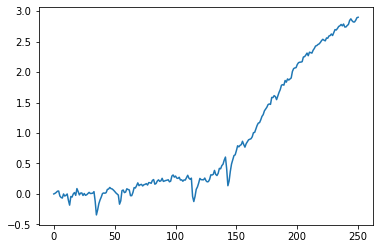

In [48]:
pl.plot(ebm.temperature[:,0])

In [ ]:
results = {}

In [ ]:
for model in models:
    print(model)
    forcing = df_forcing['%s TOT' % model].values
    results[model] = threelayermodel(forcing, params[model])

In [ ]:

    

def threelayermodel(forcing, params):
    # define results dict
    results = {}
    
    # unpack parameters
    ocean_heat_capacity = params['ocean_heat_capacity']
    ocean_heat_transfer = params['ocean_heat_transfer']
    deep_ocean_efficacy = params['deep_ocean_efficacy']
    forcing_4co2 = params.get('forcing_4co2', None)
    gamma_autocorrelation = params.get('gamma_autocorrelation', None)
    sigma_eta = params.get('sigma_eta', None)
    sigma_xi = params.get('sigma_xi', None)
    seed = params.get('seed', None)

    nbox = len(ocean_heat_capacity)
    n_timesteps = len(forcing)
    
    # check if deterministic run
    stochastic_run = True
    if None in (gamma_autocorrelation, sigma_eta, sigma_xi):
        stochastic_run = False
    nmatrix = nbox + stochastic_run
    
    # Define the matrix of differential equations
    eb_matrix = np.array(
        [
            [
                -(ocean_heat_transfer[0]+ocean_heat_transfer[1])/ocean_heat_capacity[0],
                ocean_heat_transfer[1]/ocean_heat_capacity[0], 
                0
            ],
            [
                ocean_heat_transfer[1]/ocean_heat_capacity[1],
                -(ocean_heat_transfer[1]+deep_ocean_efficacy*ocean_heat_transfer[2])/ocean_heat_capacity[1],
                deep_ocean_efficacy*ocean_heat_transfer[2]/ocean_heat_capacity[1]
            ],
            [
                0, 
                ocean_heat_transfer[2]/ocean_heat_capacity[2],
                -ocean_heat_transfer[2]/ocean_heat_capacity[2]
            ]
        ]
    )
    
    # calculate the eigenvectors and eigenvalues, these are the timescales of responses
    eb_matrix_eigenvalues, eb_matrix_eigenvectors = scipy.linalg.eig(eb_matrix)
    timescales = -1/(np.real(eb_matrix_eigenvalues))
    response_coeffs = timescales * (eb_matrix_eigenvectors[0,:] * scipy.linalg.inv(eb_matrix_eigenvectors)[:,0]) / ocean_heat_capacity[0]

    # calculate ECS and TCR from this parameter set; if 4xCO2 forcing is given
    if forcing_4co2 is not None:
        results['ecs'], results['tcr'] = emergent_parameters(response_coeffs, timescales, forcing_4co2)
    
    # Define the forcing vector
    forcing_vector = np.array([1/ocean_heat_capacity[0], 0, 0])
    
    # Prepend eb_matrix with stochastic terms if this is a stochastic run: Cummins et al. (2020) eqs. 13 and 14
    if stochastic_run:
        eb_matrix = np.insert(eb_matrix, 0, np.zeros(nbox), axis=0)
        prepend_col = np.zeros(nmatrix)
        prepend_col[0] = -gamma_autocorrelation
        prepend_col[1] = 1/ocean_heat_capacity[0]
        eb_matrix = np.insert(eb_matrix, 0, prepend_col, axis=1)
        forcing_vector = np.zeros(nmatrix)
        forcing_vector[0] = gamma_autocorrelation
    
    # Calculate the matrix exponential
    eb_matrix_d = scipy.linalg.expm(eb_matrix)
    
    # Solve for temperature
    forcing_vector_d = scipy.linalg.solve(eb_matrix, (eb_matrix_d - np.identity(nmatrix)) @ forcing_vector)
    
    # define stochastic matrix
    w_d = np.zeros((n_timesteps, nbox))
    
    # stochastic stuff
    if stochastic_run:
        Q = np.zeros((nmatrix, nmatrix))
        Q[0,0] = sigma_eta**2
        Q[1,1] = (sigma_xi/ocean_heat_capacity[0])**2
        ## use Van Loan (1978) to compute the matrix exponential
        H = np.zeros((nmatrix*2, nmatrix*2))
        H[:4,:4] = -eb_matrix
        H[:4,4:] = Q
        H[4:,4:] = eb_matrix.T
        G = scipy.linalg.expm(H)
        Q_d = G[4:,4:].T @ G[:4,4:]
        Q_d = Q_d.astype(np.float64)
        w_d = scipy.stats.multivariate_normal.rvs(size=n_timesteps, mean=np.zeros(nmatrix), cov=Q_d, random_state=seed)
    solution = np.zeros((n_timesteps, nmatrix))
    for i in range(1, n_timesteps):
        solution[i, :] = eb_matrix_d @ solution[i-1, :] + forcing_vector_d * forcing[i-1] + w_d[i-1, :]
    
    if stochastic_run:
        temperature = solution[:, 1:]
        results['stochastic_forcing'] = solution[:, 0]
    else:
        temperature = solution
    toa_imbalance = forcing - ocean_heat_transfer[0]*temperature[:,0] + (1 - deep_ocean_efficacy) * ocean_heat_transfer[2] * (temperature[:,1] - temperature[:,2])
    results['ocean_heat_content_change'] = np.cumsum(toa_imbalance) * EARTH_RADIUS**2 * 4 * np.pi * SECONDS_PER_YEAR
    results['temperature'] = temperature
    results['toa_imbalance'] = toa_imbalance
    
    return results

In [ ]:
for model in models:
    pl.plot(np.arange(1850, 2101), results[model]['temperature'][:,0], label=model)
pl.legend()

In [ ]:
for model in models:
    print(model, results[model]['ecs'], results[model]['tcr'])

In [ ]:
results['HadGEM3-GC31-LL']['temperature'][160:170,0] - np.mean(results['HadGEM3-GC31-LL']['temperature'][:51,0])

In [ ]:
pl.plot(np.arange(1850, 2015), results['HadGEM3-GC31-LL']['temperature'][:165,0])
pl.grid()

In [ ]:
# I want to see what an ensemble looks like!
n_ens = 100

ens = {}
for im, model in tqdm(enumerate(models)):
    ens[model] = {}
    for i in tqdm(range(n_ens), leave=False):
        params[model]['seed'] = im*1000+i
        forcing = df_forcing['%s TOT' % model].values
        ens[model][i] = threelayermodel(forcing, params[model])

In [ ]:
with open('../../data_output/branch_points.json', 'r') as f:
    branch_points = json.load(f)

In [ ]:
piControls = dict.fromkeys(models, 'r1i1p1f1')
piControls.update(dict.fromkeys(['CNRM-CM6-1'], 'r1i1p1f2'))
piControls

In [ ]:
cmip6_results = {}
cmip6_results['temperature'] = {}
cmip6_results['toa_imbalance'] = {}

for model in models:
    cmip6_results['temperature'][model] = {}
    cmip6_results['toa_imbalance'][model] = {}
    
    control_df = pd.read_csv('../../data_output/cmip6/%s/%s/piControl.csv' % (model, piControls[model]))
    control_tas = control_df['tas'].values
    control_rsdt = control_df['rsdt'].values
    control_rsut = control_df['rsut'].values
    control_rlut = control_df['rlut'].values

    for run in branch_points['historical'][model]:
        # Define 251 time steps but don't fill them all if ssp245 not available
        run_df = pd.read_csv('../../data_output/cmip6/%s/%s/historical.csv' % (model, run))
        cmip6_results['temperature'][model][run] = np.ones(251) * np.nan
        cmip6_results['toa_imbalance'][model][run] = np.ones(251) * np.nan
        
        cmip6_results['temperature'][model][run][:165] = (
            run_df['tas'].values - 
            control_tas[branch_points['historical'][model][run]:branch_points['historical'][model][run]+165]
        )
        cmip6_results['toa_imbalance'][model][run][:165] = (
            run_df['rsdt'].values - run_df['rsut'].values - run_df['rlut'].values - (
                control_rsdt[branch_points['historical'][model][run]:branch_points['historical'][model][run]+165] -
                control_rsut[branch_points['historical'][model][run]:branch_points['historical'][model][run]+165] - 
                control_rlut[branch_points['historical'][model][run]:branch_points['historical'][model][run]+165]
            )
        )
        
        # check to see if a continuation ssp245 run exists
        try:
            run_df = pd.read_csv('../../data_output/cmip6/%s/%s/ssp245.csv' % (model, run))
            nyears_ssp245 = np.min((86, len(run_df)))
            cmip6_results['temperature'][model][run][165:165+nyears_ssp245] = (
                run_df['tas'].values - 
                control_tas[branch_points['historical'][model][run]+165:branch_points['historical'][model][run]+165+nyears_ssp245]
            )
            cmip6_results['toa_imbalance'][model][run][165:165+nyears_ssp245] = (
                run_df['rsdt'].values - run_df['rsut'].values - run_df['rlut'].values - (
                    control_rsdt[branch_points['historical'][model][run]+165:branch_points['historical'][model][run]+165+nyears_ssp245] -
                    control_rsut[branch_points['historical'][model][run]+165:branch_points['historical'][model][run]+165+nyears_ssp245] - 
                    control_rlut[branch_points['historical'][model][run]+165:branch_points['historical'][model][run]+165+nyears_ssp245]
                )
            )
        except:
            continue

In [ ]:
fig, ax = pl.subplots(2,4, figsize=(16,9))
for im, model in enumerate(models):
    for i in range(n_ens):
        ax[im//4,im%4].plot(np.arange(1850, 2101), ens[model][i]['temperature'][:,0], color='k', alpha=0.2)
    for run in branch_points['historical'][model]:
        ax[im//4,im%4].plot(np.arange(1850, 2101), cmip6_results['temperature'][model][run], color='r', alpha=0.5)
    ax[im//4,im%4].set_xlim(1850,2100)
    ax[im//4,im%4].set_ylim(-1,6)
    ax[im//4,im%4].grid()
    ax[im//4,im%4].set_title(model)

In [ ]:
fig, ax = pl.subplots(2,4, figsize=(16,9))
for im, model in enumerate(models):
    for i in range(n_ens):
        ax[im//4,im%4].plot(np.arange(1850, 2101), ens[model][i]['toa_imbalance'], color='k', alpha=0.2)
    for run in branch_points['historical'][model]:
        ax[im//4,im%4].plot(np.arange(1850, 2101), cmip6_results['toa_imbalance'][model][run], color='r', alpha=0.5)
    ax[im//4,im%4].set_xlim(1850,2100)
    ax[im//4,im%4].set_ylim(-2,3)
    ax[im//4,im%4].grid()
    ax[im//4,im%4].set_title(model)

In [ ]:
fig, ax = pl.subplots(2,4, figsize=(16,9))
for im, model in enumerate(models):
    for i in range(n_ens):
        ax[im//4,im%4].plot(np.arange(1850, 2101), ens[model][i]['ocean_heat_content_change'], color='k', alpha=0.2)
#     for run in branch_points['historical'][model]:
#        ax[im//4,im%4].plot(np.arange(1850, 2015), cmip6_results['toa_imbalance'][model][run], color='r', alpha=0.1)
    ax[im//4,im%4].set_xlim(1850,2100)
    ax[im//4,im%4].set_ylim(-5e23, 3.5e24)
    ax[im//4,im%4].grid()
    ax[im//4,im%4].set_title(model)